# RISE: Randomized Input Sampling for Explanation of Black-box Models
#### Vitali Petsiuk, Abir Das, Kate Saenko (BMVC'2018)
https://arxiv.org/abs/1806.07421 <br>
https://github.com/eclique/RISE

If you are working from colab, go to Edit > Notebook settings > Hardware accelerator and set it to GPU for better perfromance.

In [ ]:
out = !wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip
out = !wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip
out = !wget https://www.dropbox.com/s/n4ooh6knkstdqlr/RISE_aux.zip
out = !unzip vocap.zip
out = !unzip pretrained_model.zip
out = !unzip RISE_aux.zip
out = !rm vocap.zip pretrained_model.zip RISE_aux.zip

RISE is a method for salincy attribution. Unlike the gradient-based methods that you have experimented with in the previous task, RISE is based on *perturbation*.
Perturbation methods manipulate the input and observe how changes in different input regions affect the output of the model. And based on these observations a saliency map is produced.
Types of perturbations include blacking out pixels, blurring them, adding noise, *etc*.

<img src="https://camo.githubusercontent.com/b27fb96007a21a6aefe8c3840c47490dff2e62b2/68747470733a2f2f65636c697175652e6769746875622e696f2f7265702d696d67732f524953452f726973652d6f766572766965772e706e67" style="width: 700px;"/>

RISE queries the model with many masked versions of the input and uses class probabilities computed by the model as weights for the corresponding masks. If one of the masks has removed something important for category prediction from the image, the model will produce low probability for this category, hence the mask will get a small weight in the some. Therefore, the resulting saliency map will highlight regions that the model deems important.

Formally,
$$
    S_{I, f} = \frac1{\sum_{i=1}^N M_i}\sum_{i=1}^N f(I\odot M_i)\cdot M_i,
$$
where $S_{I,f}$ is a saliency map for image $I$ and black-box model $f$, and $\{M_i\}$ is a set of $N$ masks. $f$ estimates the class probabilities $P(c_j)$.

RISE doesn't depend on any of the model's internals, such as weights, gradients or activations. It treats the model as a black box and relies only on observing it's output probabilities. Being a black-box method, it can be easily applied to different model architectures and sometimes new tasks. In this part of the class we will see, how it can be extended to produce saliency maps for image captioning models. The disadvantage of such techniques is their long runtime.

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from tqdm import tqdm

import torch.nn as nn
from torchvision import transforms, models

import caption_model_args as args
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN

### Some utility functions

In [4]:
# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0),
    lambda x: x.to(device)
])

def get_class_name(c):
    """Given label id returns imagenet class name"""
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])

def tensor_imshow(inp, sal=None, title=None):
    """Denormalizes image and displays it."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if sal is not None:
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar()
    if title is not None:
        plt.title(title)
        
def generate_masks(N, s, p1, input_size = (224, 224)):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                     anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, 1, *input_size)
    np.save(masks_filepath, masks)
    masks = torch.from_numpy(masks)
    masks = masks.float().to(device)
    return masks

## Classification

Let's first see how the method works for image classification. We generate $N$ masks, that we apply to zero out parts of the image by multiplying image tensor with the masks. The masks are upsampled from small resolution $s\times s$ binary grids where every cell has a probability $p_1$ of being set to $1$ and $1-p_1$ of being set to $0$. The masks are then upsampled to image resolution using bilinear interpolation.

#### Load the classification model

In [5]:
model = models.resnet50(pretrained=True) # Can be any classification model
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.to(device)

#### Generate RISE masks

In [6]:
masks_filepath = 'masks.npy'
N = 5000
s = 15
p1 = 0.5
force_recompute = False

if force_recompute or not os.path.isfile(masks_filepath):
    masks = generate_masks(N, s, p1, input_size=(224, 224))
else:
    masks = np.load(masks_filepath)
    masks = torch.from_numpy(masks)
    masks = masks.float().to(device)    
mask_sum = masks.sum(0)[0].cpu().numpy() # For normalization

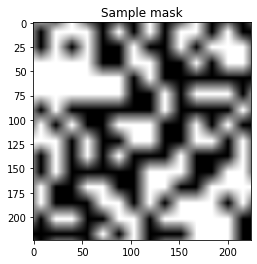

In [7]:
plt.title('Sample mask')
plt.imshow(masks[0, 0].cpu(), cmap='gray')
plt.show()

#### Saliency maps for classification

In [7]:
# Load an image
img_t = read_tensor('samples/COCO_val2014_000000000283.jpg')
_, _, H, W = img_t.size() # Image dimentions
stack = None
# Apply array of masks to the image
stack = torch.mul(masks, img_t)

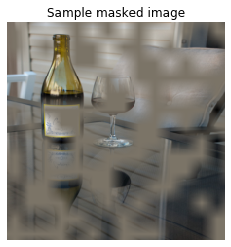

In [8]:
tensor_imshow(stack[0].cpu(), title='Sample masked image')
plt.show()

Run the model on masked images, compute the probabilities and generate saliency maps for all caetgories in one pass.

In [44]:
# Equivalent to p = model(stack) processed in batches
gpu_batch = 250
p = []
with torch.no_grad():
    for i in tqdm(range(0, N, gpu_batch), desc='Running model on masked images'):
        p.append(model(stack[i:min(i + gpu_batch, N)]))
p = torch.cat(p)

Running model on masked images: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


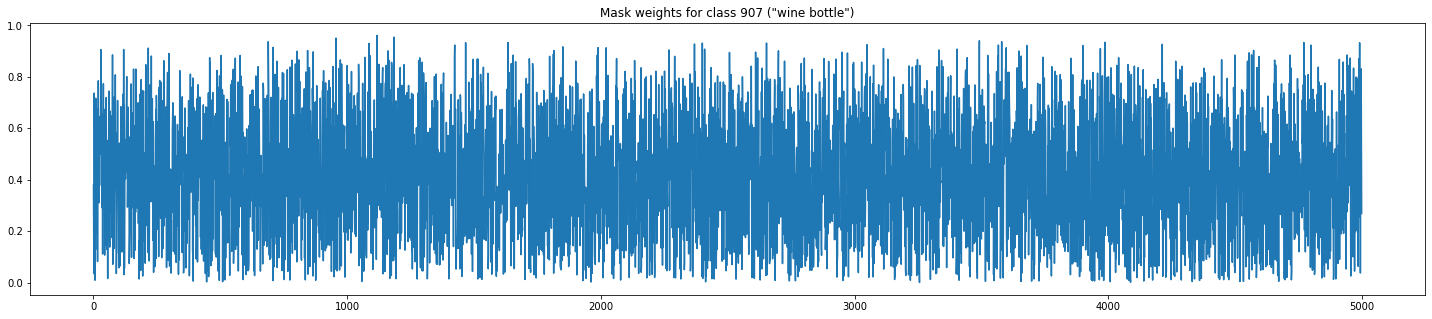

In [50]:
plt.figure(figsize=(25, 5))
plt.title('Mask weights for class 907 ("wine bottle")')
plt.plot(p[:, 907].cpu())
plt.show()

In [51]:
# Compute weighted sum, reshape and normalize
CL = p.size(1) # Number of classes
sal = torch.matmul(p.transpose(0, 1), masks.view(N, H * W))
sal = sal.view((CL, H, W))
sal = sal.cpu().numpy() / mask_sum

In [52]:
def show_results(img, sal, top_k=3):
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0], sal[c[k]])
    plt.show()

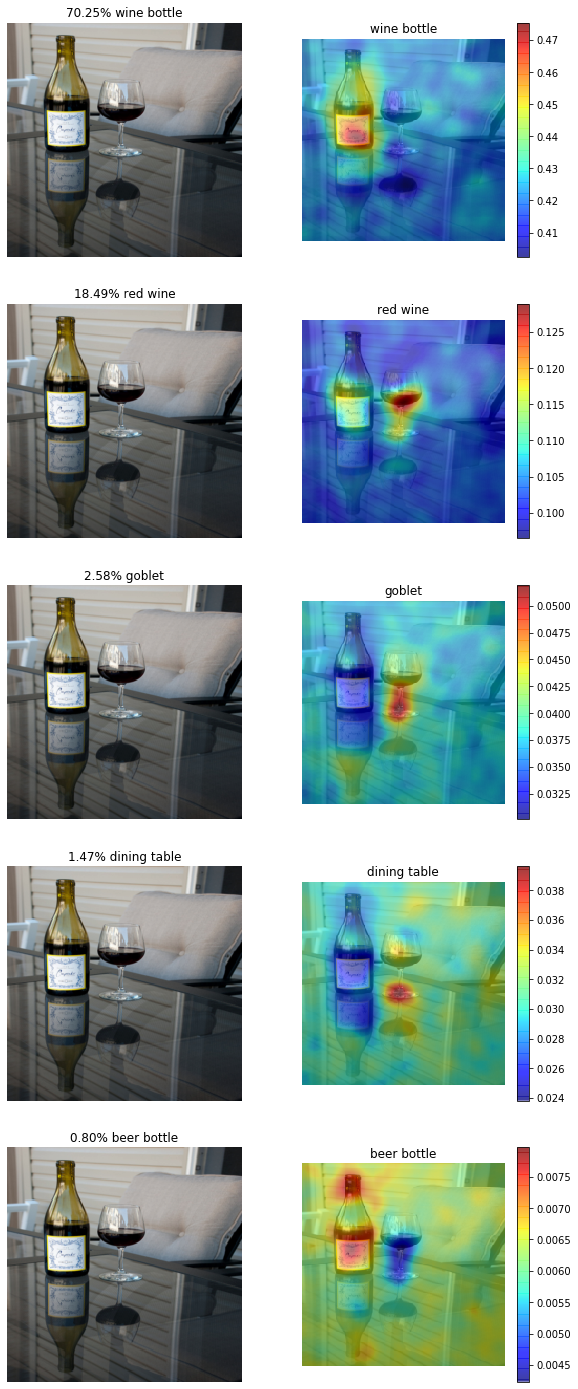

In [53]:
show_results(img_t.cpu(), sal, top_k=5)

## Image Captioning

The image captioning models and code are taken from this repo:<br>
https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

<img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" style="width: 700px;"/>

Let's see how we can extend the method for a different task: Image Captioning. 
Here's how our model works during inference. It consists of an encoder (blue) and a decoder (red).
1. Encoder computes the image features using a CNN (resnet152)
2. Decoder is a recurrent layer (LSTM) followed by a Softmax. At the first step it takes CNN features as input and outputs probabilities for the first word $P(w_1 \mid I)$.
3. At every following $i$-th step decoder takes the embedding of the previously generated word as input and produces probabilities for the next, $i$-th, word. 
4. This process ends once the model produces \<end\> token or it reaches the maximum number of iterations.

Thus, the model estimates probability $P(w_i \mid I; w_0, \ldots, w_{i-1})$ at every step. We will use these probabilities to weight the masks as we did with class probabilities $P(c_j)$ in classification. The resulting saliency map will correspond to the word $w_i$ in the caption. 

#### Load captioning model

In [17]:
# Load vocabulary wrapper
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)
    
# Build Models
encoder = EncoderCNN(args.embed_size)
encoder.eval()  # evaluation mode (BN uses moving mean/variance)
decoder = DecoderRNN(args.embed_size, args.hidden_size, 
                     len(vocab), args.num_layers)

# Load the trained model parameters
encoder.load_state_dict(torch.load(args.encoder_path))
decoder.load_state_dict(torch.load(args.decoder_path))

encoder.to(device)
decoder.to(device)
pass

Let's see what captions this model generates.

Captioning image COCO_val2014_000000000074.jpg
<start> a dog is walking down the sidewalk with a bicycle . <end>


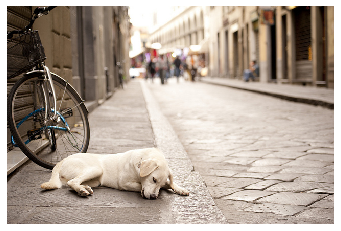

Captioning image COCO_val2014_000000000283.jpg
<start> a glass of wine on a table with a wine glass . <end>


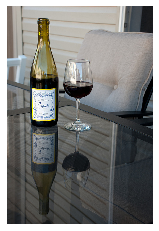

Captioning image COCO_val2014_000000012443.jpg
<start> a cat sitting on a table next to a laptop computer . <end>


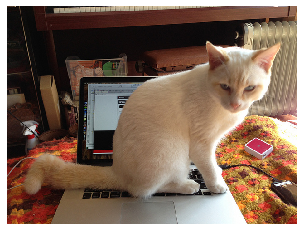

In [80]:
for i, imname in enumerate(os.listdir('samples')):
    print('Captioning image ' + imname)
    # Prepare Image
    img_path = 'samples/' + imname
    image_tensor = read_tensor(img_path)

    # Generate caption from image
    with torch.no_grad():
        feature = encoder(image_tensor)
        # sampled_ids encodes the whole sentence produced by the model
        sampled_ids = decoder.sample(feature)
    
    # Decode word_ids to words
    sampled_ids_np = sampled_ids.cpu().data.numpy()
    sampled_caption = []
    for word_id in sampled_ids_np:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)        
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    # Print out image and generated caption.
    print(sentence)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()

### Generating saliency maps

First, we generate random masks, same as we did in classification.

In [8]:
masks_filepath = 'masks.npy'
N = 5000
s = 15
p1 = 0.5
force_recompute = False

if force_recompute or not os.path.isfile(masks_filepath):
    masks = generate_masks(N, s, p1)
else:
    masks = np.load(masks_filepath)
    masks = torch.from_numpy(masks)
    masks = masks.float().to(device)    
mask_sum = masks.sum(0)[0].cpu().numpy()

Look at the following method that was used by decoder to produce `sampled_ids`.<br>
At each step `outputs` variable contains the logits for word probabilities, i.e. `nn.Softmax(1)(outputs)` would have the actual probability $P(w_i \mid w_0, \ldots, w_{i-1})$.

In [31]:
def sample(self, features, states=None):
    """Samples captions for given image features (Greedy search)."""
    sampled_ids = []
    # Use image features as input for the 1st step
    inputs = features.unsqueeze(1)
    for i in range(20):                                      # maximum sampling length
        hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
        outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
        predicted = outputs.max(1)[1]
        sampled_ids.append(predicted)
        inputs = self.embed(predicted)
        inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
    sampled_ids = torch.cat(sampled_ids, 0)                  # (batch_size, 20)
    return sampled_ids.squeeze()

Based on the code above, let's write a function what will return $P(w_i \mid I; w_0, \ldots, w_{i-1})$, given `features` = CNN features of $I$, `prefix`=$[w_0, \ldots, w_{i-1}]$ and the `next_word`=$w_i$.

In [54]:
def compute_probabilities(decoder, features, prefix, next_word, states=None):    
    inputs = features.unsqueeze(1)
    for i in range(len(prefix)):
        hiddens, states = decoder.lstm(inputs, states)
        predicted = prefix[i]
        inputs = decoder.embed(predicted)
        inputs = inputs.expand(features.size(0), features.size(1))
        inputs = inputs.unsqueeze(1)
    hiddens, states = decoder.lstm(inputs, states)
    outputs = decoder.linear(hiddens.squeeze(1))
    outputs = nn.Softmax(1)(outputs)
    return outputs[:, next_word]

Let's see how it works for a given image. First, we load the image and compute the caption for it.

(0, '<start>') (1, 'a') (2, 'cat') (3, 'sitting') (4, 'on') (5, 'a') (6, 'table') (7, 'next') (8, 'to') (9, 'a') (10, 'laptop') (11, 'computer') (12, '.') (13, '<end>')


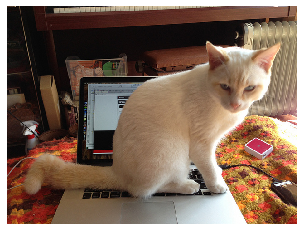

In [55]:
imname = 'COCO_val2014_000000012443.jpg'

# Prepare Image
img_path = 'samples/' + imname
image_tensor = read_tensor(img_path)

# Generate caption from image
with torch.no_grad():
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)

# Decode word_ids to words
sampled_ids_np = sampled_ids.cpu().data.numpy()
sampled_caption = []
n_words = 0
for i, word_id in enumerate(sampled_ids_np):
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
    n_words += 1
print(' '.join(map(str, enumerate(sampled_caption))))
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.show()

Now, similarly to classification, implement RISE for captioning. Choose a word to explain and use the words preceding it as prefix.

#### Classification
(no need to run)

In [ ]:
# Equivalent to p = model(stack) processed in batches
gpu_batch = 250
p = []
with torch.no_grad():
    for i in tqdm(range(0, N, gpu_batch), desc='Running model on masked images'):
        p.append(model(stack[i:min(i + gpu_batch, N)]))
p = torch.cat(p)

# Compute weighted sum, reshape and normalize
CL = p.size(1) # Number of classes
sal = torch.matmul(p.transpose(0, 1), masks.view(N, H * W))
sal = sal.view((CL, H, W))
sal = sal.cpu().numpy() / mask_sum

#### Captioning

In [61]:
# Set to a different index to explain other words
explain_word_ind = sampled_caption.index('laptop')
explain_word = sampled_caption[explain_word_ind]

stack = None
stack = torch.mul(masks, image_tensor.data.cuda())
stack = stack.to(device)

Hint. Compute probabilities should be called like this:<br>
`cur_p = compute_probabilities(decoder, cur_features, sampled_ids[:eplain_word_ind], sampled_ids[explain_word_ind].item())`

Compute probabilities `p` (i.e. mask weights):

In [ ]:
# ====================
# Your code goes here
# ====================

Should look like this

In [83]:
print(p)
print(p.shape)

tensor([0.0105, 0.0313, 0.0079,  ..., 0.1065, 0.0821, 0.1292], device='cuda:0')
torch.Size([5000])


Answer:

In [62]:
gpu_batch = 250
p = []
with torch.no_grad():
    for i in tqdm(range(0, N, gpu_batch), desc='Explaining ' + explain_word):
        cur_features = encoder(stack[i:min(i + gpu_batch, N)])
        # explain some word in a generated caption    
        cur_p = compute_probabilities(decoder, cur_features, sampled_ids[:explain_word_ind], sampled_ids[explain_word_ind].item())        
        p.append(cur_p)
p = torch.cat(p)

Explaining laptop: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Compute saliency `sal` by summing masks with corresponding weights:

In [ ]:
# ====================
# Your code goes here
# ====================

Should look like this

In [84]:
print(sal)
print(sal.shape)

tensor([[0.0629, 0.0629, 0.0629,  ..., 0.0655, 0.0655, 0.0656],
        [0.0630, 0.0629, 0.0630,  ..., 0.0655, 0.0655, 0.0655],
        [0.0630, 0.0630, 0.0630,  ..., 0.0654, 0.0654, 0.0655],
        ...,
        [0.0625, 0.0626, 0.0626,  ..., 0.0640, 0.0641, 0.0643],
        [0.0625, 0.0625, 0.0626,  ..., 0.0640, 0.0641, 0.0643],
        [0.0624, 0.0625, 0.0625,  ..., 0.0639, 0.0641, 0.0642]])
torch.Size([224, 224])


Answer:

In [78]:
sal = torch.matmul(p.data, masks.view(N, H * W))
sal = sal.view((H, W)).cpu().numpy() / mask_sum

#### Result

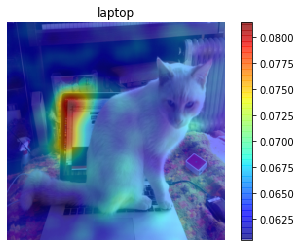

In [80]:
tensor_imshow(image_tensor[0].data.cpu(), sal, title=explain_word)
plt.show()

#### More examples:

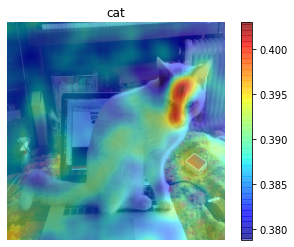

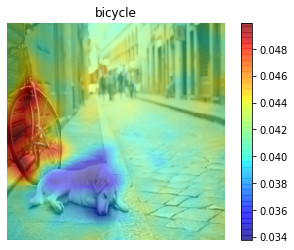

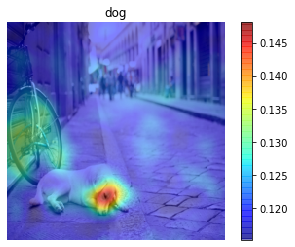

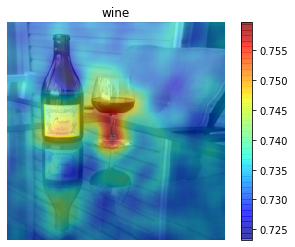

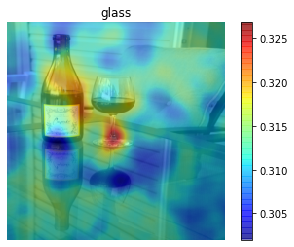

#### If you want to experiment more:
* Try different RISE mask generation parameters ($N$, $s$, $p_1$).
* Try different classification models.
* Explain not the produced caption, but an arbitrary prefix+word.
* This can be extended to explaining whole sentences instead of words ($P(w_1, \ldots, w_n \mid I)$).